In [1]:
import importlib
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')

from __init__ import *
from __init__jupyterlab import *
import datetime
from scipy import sparse
import collections
import itertools
import re
import fbpca
import pickle
import scipy.cluster.hierarchy as sch
from sklearn.metrics import euclidean_distances

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_run_tsne
import CEMBA_clst_utils
import SCF_utils
importlib.reload(SCF_utils)

import seaborn as sns 
import matplotlib.pyplot as plt

# Configs  

In [2]:
time_stamp = datetime.datetime.now().date()
print(time_stamp)

# config_dir = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons/' 
# sys.path.insert(0, config_dir)
config_f = 'config_scf_8mods_data_freeze_190917.py' 
exec("from {} import *".format(config_f.split('.')[0]))
output_figures = '/cndd/fangming/CEMBA/data/MOp_all/results/figures/mop_liger_{{}}_{}.{{}}'.format(time_stamp)

dirc = '/cndd/fangming/CEMBA/data/MOp_all/josh_welch'
f_joint_clustering = dirc + '/LIGER_organized_FX2.tsv'
f_cluster_annot = dirc + '/LIGER_organized_annot_FX2.tsv'
f_mod_annot = '/cndd/fangming/CEMBA/data/MOp_all/results_final/miniatlas_datamod_annotation.tsv'

# output_summary_results = '/cndd/fangming/CEMBA/data/MOp_all/results_final/miniatlas_fig4_scf_clusterings.tsv' 
# output_summary_results = os.path.join(outdir, 'intg_summary-{}-2-round-clustering.tsv'.format(name))
# output_summary_results = os.path.join(outdir, 'intg_summary-{}-2-round-clustering.tsv'.format(name))
# print(output_summary_results)

2020-01-09


In [3]:
output_figures

'/cndd/fangming/CEMBA/data/MOp_all/results/figures/mop_liger_{}_2020-01-09.{}'

In [4]:
# fixed dataset configs
sys.path.insert(0, DATA_DIR)
import __init__datasets
importlib.reload(__init__datasets)
from __init__datasets import *

meta_f = os.path.join(DATA_DIR, '{0}_metadata.tsv')
hvftrs_f = os.path.join(DATA_DIR, '{0}_hvfeatures.{1}')
hvftrs_gene = os.path.join(DATA_DIR, '{0}_hvfeatures.gene')
hvftrs_cell = os.path.join(DATA_DIR, '{0}_hvfeatures.cell')

## Read in data 

In [5]:
log = snmcseq_utils.create_logger()
logging.info('*')

01/09/2020 10:23:15 PM *


In [6]:
metas = collections.OrderedDict()
for mod in mods_selected:
    metas[mod] = pd.read_csv(meta_f.format(mod), sep="\t").reset_index().set_index(settings[mod].cell_col)
    print(mod, metas[mod].shape)

snmcseq_gene (9366, 32)
snatac_gene (54844, 13)


/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


smarter_cells (6244, 129)
smarter_nuclei (5911, 146)
10x_cells_v2 (121440, 8)
10x_cells_v3 (69727, 8)
10x_nuclei_v3 (39706, 8)
10x_nuclei_v3_macosko (101647, 19)


## All done, making plots after 

- Plotting packages

In [7]:
# get results summary
mods_ordered = [
    'snatac_gene',
    'snmcseq_gene',
    'smarter_nuclei',
    'smarter_cells',
    '10x_cells_v3',
    '10x_nuclei_v3',
    '10x_nuclei_v3_macosko',
    '10x_cells_v2', 
    ]
assert set(mods_ordered) == set(mods_selected)

f = f_cluster_annot
df_annot = pd.read_csv(f, sep="\t") 

f = f_mod_annot
df_mod_annot = pd.read_csv(f, sep="\t", index_col='Modality') 

f = f_joint_clustering
df_info = pd.read_csv(f, sep="\t", index_col=0) 

# back compatible
df_info = pd.merge(df_info, df_mod_annot[['Name']], left_on='modality', right_index=True)
df_info['modality_name'] = df_info['Name']
df_info = df_info.drop('Name', axis=1)

# df_info = pd.merge(df_info, df_annot[['cluster_id_iterative', 'annotation_curated', 'color']], 
#                    left_on='joint_cluster_round3', right_on='cluster_id_iterative', )

# df_info = df_info.rename(columns={
#                 'joint_embedding_x': 'tsne_x_joint',
#                 'joint_embedding_y': 'tsne_y_joint',
#                 'single_modality_annot': 'annot',
#                 'single_modality_cluster': 'cluster',
#                 'annotation_curated': 'joint_cluster_round3_anno',
#                 'color': 'joint_cluster_round3_color',
#             }).drop('cluster_id_iterative', axis=1)

print(df_info.shape)
df_info.head()


(408736, 12)


,level1_UMAP_1,level1_UMAP_2,level2_UMAP_1,level2_UMAP_2,level1_cluster,level2_cluster,modality,modality_name,single_modality_cluster,single_modality_annot,annot,color
cell,,,,,,,,,,,,
SM-GE653_S113_E1-50,-3.164615,12.190200,4.718955,-2.380108,10,cge_5,smarter_nuclei,snRNA SMART,2,Lamp5 Egln3_2,Lamp5 Pax6,#DDACC9
SM-GE653_S117_E1-50,-3.395991,11.764448,2.380869,-2.322626,10,cge_5,smarter_nuclei,snRNA SMART,2,Lamp5 Egln3_2,Lamp5 Pax6,#DDACC9
SM-GE653_S118_E1-50,-2.278710,12.773043,6.417862,-1.314918,8,cge_5,smarter_nuclei,snRNA SMART,9,Vip Cbln4,Lamp5 Pax6,#DDACC9
SM-GE653_S120_E1-50,-2.899099,12.395375,5.662322,-2.015199,10,cge_5,smarter_nuclei,snRNA SMART,2,Lamp5 Egln3_2,Lamp5 Pax6,#DDACC9
SM-GE653_S122_E1-50,-3.567551,11.620143,2.055580,-3.102450,10,cge_5,smarter_nuclei,snRNA SMART,2,Lamp5 Egln3_2,Lamp5 Pax6,#DDACC9


In [8]:
df_info = df_info.rename(columns={
      'level1_UMAP_1': 'tsne_x_joint',
      'level1_UMAP_2': 'tsne_y_joint',
      'level2_cluster': 'joint_cluster_round3', 
      'annot': 'joint_cluster_round3_anno',
      'color': 'joint_cluster_round3_color',
      
      'single_modality_annot': 'annot',
      'single_modality_cluster': 'cluster',
    })

In [9]:
df_annot = df_annot.rename(columns={
    'cluster': 'cluster_id_iterative', 
    'annot': 'annotation_curated',
    })

In [10]:
df_info.head()

,tsne_x_joint,tsne_y_joint,level2_UMAP_1,level2_UMAP_2,level1_cluster,joint_cluster_round3,modality,modality_name,cluster,annot,joint_cluster_round3_anno,joint_cluster_round3_color
cell,,,,,,,,,,,,
SM-GE653_S113_E1-50,-3.164615,12.190200,4.718955,-2.380108,10,cge_5,smarter_nuclei,snRNA SMART,2,Lamp5 Egln3_2,Lamp5 Pax6,#DDACC9
SM-GE653_S117_E1-50,-3.395991,11.764448,2.380869,-2.322626,10,cge_5,smarter_nuclei,snRNA SMART,2,Lamp5 Egln3_2,Lamp5 Pax6,#DDACC9
SM-GE653_S118_E1-50,-2.278710,12.773043,6.417862,-1.314918,8,cge_5,smarter_nuclei,snRNA SMART,9,Vip Cbln4,Lamp5 Pax6,#DDACC9
SM-GE653_S120_E1-50,-2.899099,12.395375,5.662322,-2.015199,10,cge_5,smarter_nuclei,snRNA SMART,2,Lamp5 Egln3_2,Lamp5 Pax6,#DDACC9
SM-GE653_S122_E1-50,-3.567551,11.620143,2.055580,-3.102450,10,cge_5,smarter_nuclei,snRNA SMART,2,Lamp5 Egln3_2,Lamp5 Pax6,#DDACC9


In [11]:
df_annot.head(1)

,cluster_id_iterative,annotation_curated,color
0,cge_0,Lamp5 Slc35d3,#FFA388


In [12]:
# back compatible
# update settings
settings_new = collections.OrderedDict()
for mod, mod_info in settings.items():
    new_dict = collections.OrderedDict()
    for item_key in mod_info._asdict().keys():
        if item_key == 'name':
            new_dict[item_key] = df_mod_annot.loc[mod, 'Name'] 
        elif item_key == 'color':
            new_dict[item_key] = df_mod_annot.loc[mod, 'Color'] 
        else:
            # unchanged 
            new_dict[item_key] = mod_info._asdict()[item_key]
    
    _items = [val for key, val in new_dict.items()]
    settings_new[mod] = Mod_info(*_items) 
settings = settings_new
# settings

In [13]:
joint_cluster = 'joint_cluster_round3'
joint_annot = df_annot.set_index('cluster_id_iterative').rename(columns={'color': 'cluster_color', 
                                                                         'annotation_curated': 'annot',
                                                                        })

# mod colors and names
mod_colors = collections.OrderedDict({mod: settings[mod].color for mod in mods_ordered})
mod_names = {mod: settings[mod].name for mod in mods_ordered}

# get cluster centroids
centroids = {}
_x = (df_info[['tsne_x_joint', 'tsne_y_joint', 'annot', 'modality']]
             .groupby(['modality', 'annot']).median())
for mod in mods_selected:
    centroids[mod] = _x.loc[mod, :]
centroids['joint'] = (df_info[['tsne_x_joint', 'tsne_y_joint', joint_cluster]]
             .groupby([joint_cluster]).median())

# # get annotation for joint clusters 
# joint_annot = df_info[df_info['modality'].isin(features_selected)].groupby([joint_cluster]).agg({'annot': lambda x: x.value_counts().index.values[0]})
# joint_annot = pd.merge(joint_annot, 
#                        metas['10x_cells_v2'].groupby(settings['10x_cells_v2'].annot_col).first()[['cluster_color']], 
#                        left_on='annot', 
#                        right_index=True,
#                       )
# df_info[joint_cluster+'_anno'] = df_info[joint_cluster].apply(lambda x: joint_annot.loc[x, 'annot'])
# df_info[joint_cluster+'_color'] = df_info[joint_cluster].apply(lambda x: joint_annot.loc[x, 'cluster_color'])

# get uniq colors for joint clusters  
joint_clst_colors = joint_annot['cluster_color'].to_dict()
# clsts = np.sort(df_info[joint_cluster].unique())
# colors = snmcseq_utils.gen_colors(len(clsts))
# joint_clst_colors = {clst: color for clst, color in zip(clsts, colors)}

# histograms
hist = df_info.groupby([joint_cluster, 'modality']).size().unstack().fillna(0).astype(int)
hist_mod = hist.sum(axis=0)
hist_clst = hist.sum(axis=1)
hist_frac = hist.divide(hist_clst, axis=0)
hist_exp = pd.DataFrame(np.outer(hist_clst/hist_clst.sum(), hist_mod), 
             index=hist_clst.index, columns=hist_mod.index.values)
hist_enrich = (hist+1)/(hist_exp+1)

# clst_order 
clsts_order = df_info.groupby(joint_cluster).size().sort_values(ascending=False).index.values

print(df_info.shape)
df_info.head()

(408736, 12)


,tsne_x_joint,tsne_y_joint,level2_UMAP_1,level2_UMAP_2,level1_cluster,joint_cluster_round3,modality,modality_name,cluster,annot,joint_cluster_round3_anno,joint_cluster_round3_color
cell,,,,,,,,,,,,
SM-GE653_S113_E1-50,-3.164615,12.190200,4.718955,-2.380108,10,cge_5,smarter_nuclei,snRNA SMART,2,Lamp5 Egln3_2,Lamp5 Pax6,#DDACC9
SM-GE653_S117_E1-50,-3.395991,11.764448,2.380869,-2.322626,10,cge_5,smarter_nuclei,snRNA SMART,2,Lamp5 Egln3_2,Lamp5 Pax6,#DDACC9
SM-GE653_S118_E1-50,-2.278710,12.773043,6.417862,-1.314918,8,cge_5,smarter_nuclei,snRNA SMART,9,Vip Cbln4,Lamp5 Pax6,#DDACC9
SM-GE653_S120_E1-50,-2.899099,12.395375,5.662322,-2.015199,10,cge_5,smarter_nuclei,snRNA SMART,2,Lamp5 Egln3_2,Lamp5 Pax6,#DDACC9
SM-GE653_S122_E1-50,-3.567551,11.620143,2.055580,-3.102450,10,cge_5,smarter_nuclei,snRNA SMART,2,Lamp5 Egln3_2,Lamp5 Pax6,#DDACC9


In [15]:
def plot_1():
    from matplotlib.gridspec import GridSpec

    sample_n = min(len(df_info), 20000)
    n_resolutions = len(resolutions)
    fig = plt.figure(figsize=(8*2,6*2))
    gs = GridSpec(2, n_resolutions)

    ax = fig.add_subplot(gs[0, :])
    kw_colors = {settings[mod].name: settings[mod].color for mod in mods_ordered}
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'modality_name'
    legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                      legend_kws=legend_kws,
                                      kw_colors=kw_colors,
                                      sample_n=sample_n,
                                      legend_size=30,
                                      rasterized=True,
                                      s=2,
                                     )
    ax.set_aspect('equal')
    ax.axis('off')

    layouts = [(1, i) for i in range(n_resolutions)]
    for resolution, layout in zip(resolutions, layouts):
        ax = fig.add_subplot(gs[layout[0], layout[1]])
        tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'cluster_joint_r{}'.format(resolution)
        snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                          legend_mode=-1,
                                          sample_n=sample_n,
                                          rasterized=True,
                                          s=2,
                                         )
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title('{} joint clusters (r={})'.format(len(df_info[tc].unique()), resolution))

    fig.tight_layout()
    fig.savefig(output_figures.format(1, 'pdf'), bbox_inches='tight', dpi=300)
    plt.show()

In [19]:
def plot_1_single(df_info, kw_colors='', show_labels=False, centroids='', output=''):
    """plot umap cluster 
    """
    fig, ax = plt.subplots(1, 1, figsize=(8*1,8*1))
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', joint_cluster
    legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                         #  legend_kws=legend_kws,
                                      sample_n=sample_n,
                                      legend_size=30,
                                      rasterized=True,
                                      kw_colors=kw_colors,
                                      legend_mode=-1,
                                      s=2,
                                     )
    ax.set_aspect('equal')
    ax.axis('off')
    if show_labels:
        for clst, centroid in centroids['joint'].iterrows():
            facecolor='white'
            ax.text(centroid.values[0], 
                    centroid.values[1], 
                    str(clst)+'_'+joint_annot.loc[clst, 'annot'],
                    color='black', 
                    bbox=dict(facecolor=facecolor, alpha=0.3, edgecolor='black', boxstyle='round,pad=0.1'),
                    fontsize=10,
                   )

    fig.savefig(output, bbox_inches='tight', dpi=300)
    plt.show()
        
def plot_2_single(df_info, output=''):
    """Plot umap - modality
    """
    fig, ax = plt.subplots(1, 1, figsize=(8*1,8*1))
    kw_colors = {settings[mod].name: settings[mod].color for mod in mods_selected}
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'modality_name'
    legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                      legend_kws=legend_kws,
                                      sample_n=sample_n,
                                      legend_size=30,
                                      rasterized=True,
                                      kw_colors=kw_colors,
                                      s=2,
                                     )
    ax.set_aspect('equal')
    ax.axis('off')

    fig.savefig(output, bbox_inches='tight', dpi=300)
    plt.show()

def plot_3(output='', 
           show_labels=False):
    """Plot umap - cluster - each modality
    """
    n = len(mods_selected)
    nx = 3
    ny = int((n+nx-1)/nx)
    fig, axs = plt.subplots(ny, nx, figsize=(6*nx,6*ny))
    axs = axs.flatten()
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'cluster'

    for ax, mod in zip(axs, mods_selected):
        snmcseq_utils.plot_tsne_labels_ax(df_info[df_info['modality']==mod], ax, tx, ty, tc, 
                                          sample_n=sample_n,
                                          legend_mode=-1,
                                          rasterized=True,
                                          s=2,
                                         )
        ax.set_title('{} ({} clusters)'.format(settings[mod].name, len(df_info.loc[df_info['modality']==mod, tc].unique())))
    
        if show_labels:
            for clst, centroid in centroids[mod].iterrows():
                facecolor='white'
                ax.text(centroid.values[0], 
                        centroid.values[1], 
                        clst,
                        color='black', 
                        bbox=dict(facecolor=facecolor, alpha=0.3, edgecolor='black', boxstyle='round,pad=0.1'),
                        fontsize=10,
                       )
        ax.set_aspect('equal')
        ax.axis('off')
    for ax in axs[n:]:
        ax.axis('off')


    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    fig.savefig(output, bbox_inches='tight', dpi=300)
    plt.show()


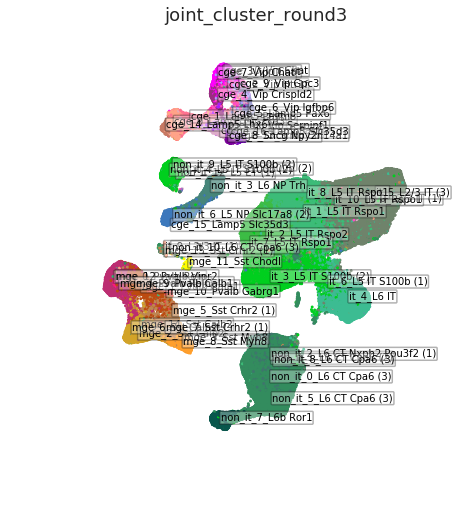

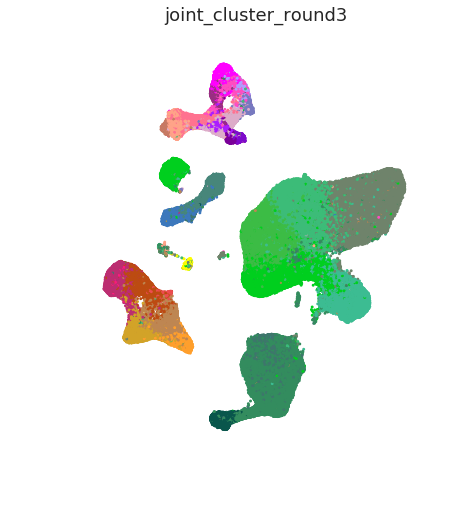

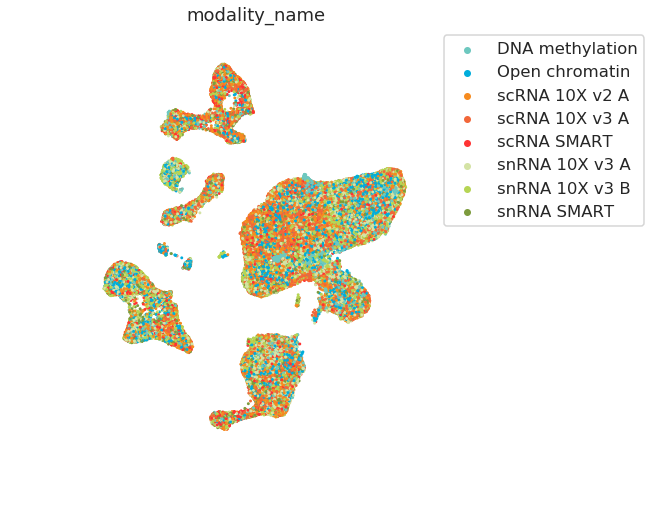

In [47]:
sample_n = 20000
# umap cluster
plot_1_single(df_info, joint_clst_colors, show_labels=True, output=output_figures.format('round2_1-label', 'pdf'))
plot_1_single(df_info, joint_clst_colors, show_labels=False, output=output_figures.format('round2_1-nolabel', 'pdf'))
plot_2_single(df_info, output=output_figures.format('round2_2-nolabel', 'pdf'))

In [17]:
df_info_cge = df_info[df_info['joint_cluster_round3'].str.contains(r'^cge')].drop(['tsne_x_joint', 'tsne_y_joint'], axis=1).rename(columns={'level2_UMAP_1': 'tsne_x_joint', 'level2_UMAP_2': 'tsne_y_joint'})
print(df_info_cge.shape)
df_info_mge = df_info[df_info['joint_cluster_round3'].str.contains(r'^mge')].drop(['tsne_x_joint', 'tsne_y_joint'], axis=1).rename(columns={'level2_UMAP_1': 'tsne_x_joint', 'level2_UMAP_2': 'tsne_y_joint'})
print(df_info_mge.shape)
df_info_it = df_info[df_info['joint_cluster_round3'].str.contains(r'^it')].drop(['tsne_x_joint', 'tsne_y_joint'], axis=1).rename(columns={'level2_UMAP_1': 'tsne_x_joint', 'level2_UMAP_2': 'tsne_y_joint'})
print(df_info_it.shape)
df_info_nonit = df_info[df_info['joint_cluster_round3'].str.contains(r'^non')].drop(['tsne_x_joint', 'tsne_y_joint'], axis=1).rename(columns={'level2_UMAP_1': 'tsne_x_joint', 'level2_UMAP_2': 'tsne_y_joint'})
print(df_info_nonit.shape)


(35066, 10)
(37075, 10)
(235557, 10)
(101038, 10)


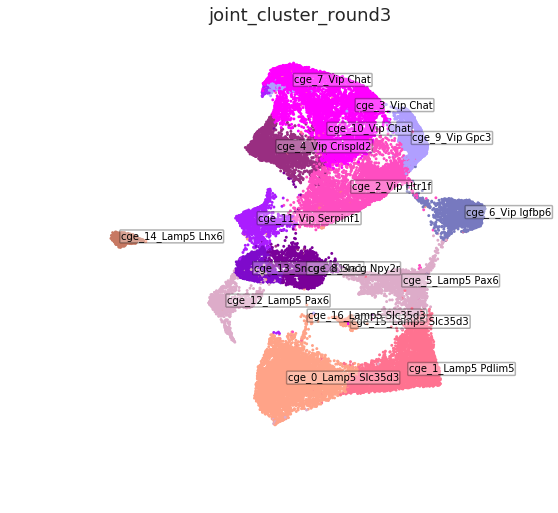

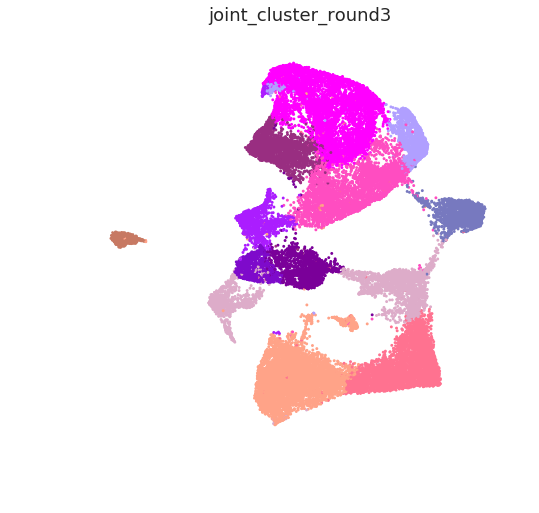

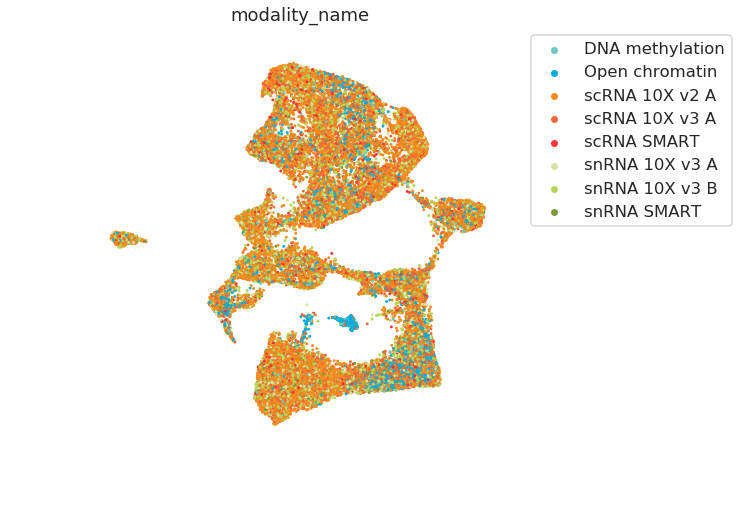

In [20]:
sample_n = 20000

# get cluster centroids
centroids_cge = {}
_x = (df_info_cge[['tsne_x_joint', 'tsne_y_joint', 'annot', 'modality']]
             .groupby(['modality', 'annot']).median())
for mod in mods_selected:
    centroids_cge[mod] = _x.loc[mod, :]
centroids_cge['joint'] = (df_info_cge[['tsne_x_joint', 'tsne_y_joint', joint_cluster]]
             .groupby([joint_cluster]).median())

# umap cluster
plot_1_single(df_info_cge, joint_clst_colors, show_labels=True, centroids=centroids_cge, output=output_figures.format('cge_1-label', 'pdf'))
plot_1_single(df_info_cge, joint_clst_colors, show_labels=False, output=output_figures.format('cge_1-nolabel', 'pdf'))
plot_2_single(df_info_cge, output=output_figures.format('cge_2-nolabel', 'pdf'))

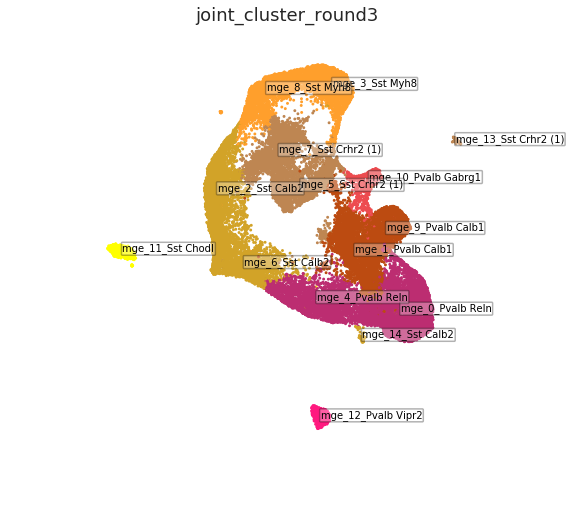

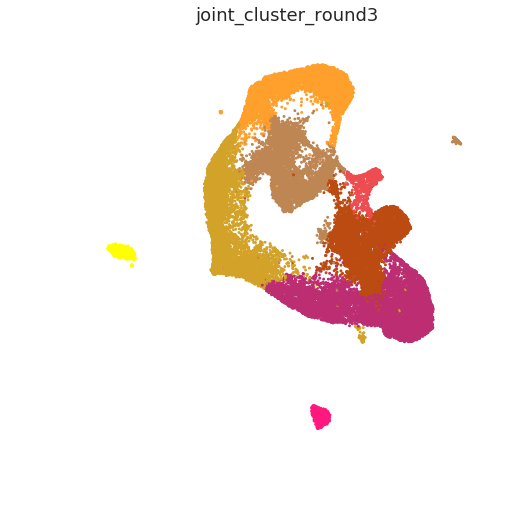

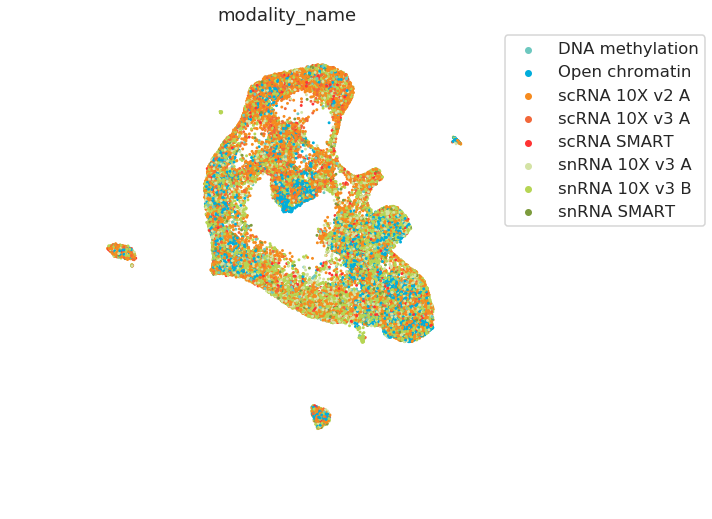

In [25]:
sample_n = 20000

# get cluster centroids
centroids_mge = {}
_x = (df_info_mge[['tsne_x_joint', 'tsne_y_joint', 'annot', 'modality']]
             .groupby(['modality', 'annot']).median())
for mod in mods_selected:
    centroids_mge[mod] = _x.loc[mod, :]
centroids_mge['joint'] = (df_info_mge[['tsne_x_joint', 'tsne_y_joint', joint_cluster]]
             .groupby([joint_cluster]).median())

# umap cluster
plot_1_single(df_info_mge, joint_clst_colors, show_labels=True, centroids=centroids_mge, output=output_figures.format('mge_1-label', 'pdf'))
plot_1_single(df_info_mge, joint_clst_colors, show_labels=False, output=output_figures.format('mge_1-nolabel', 'pdf'))
plot_2_single(df_info_mge, output=output_figures.format('mge_2-nolabel', 'pdf'))

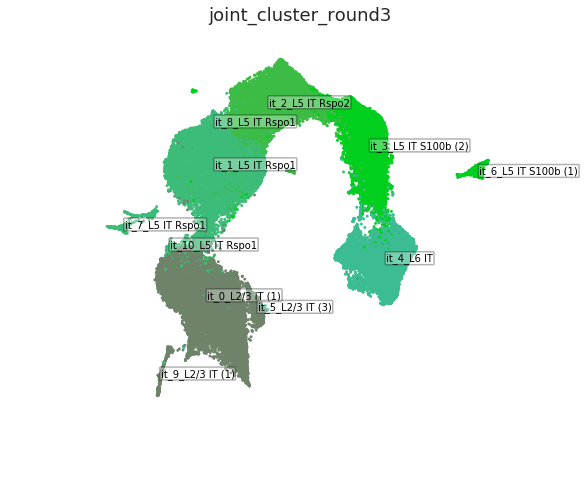

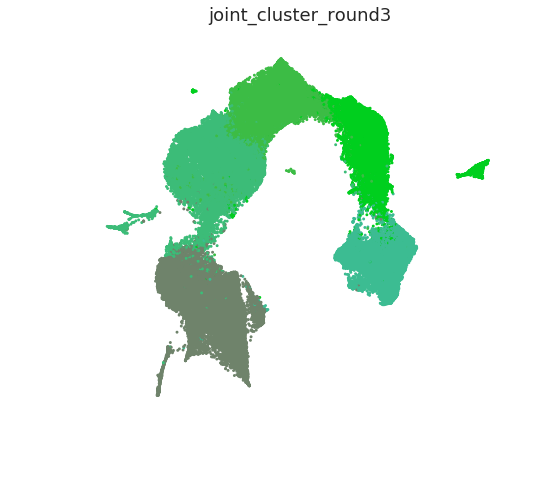

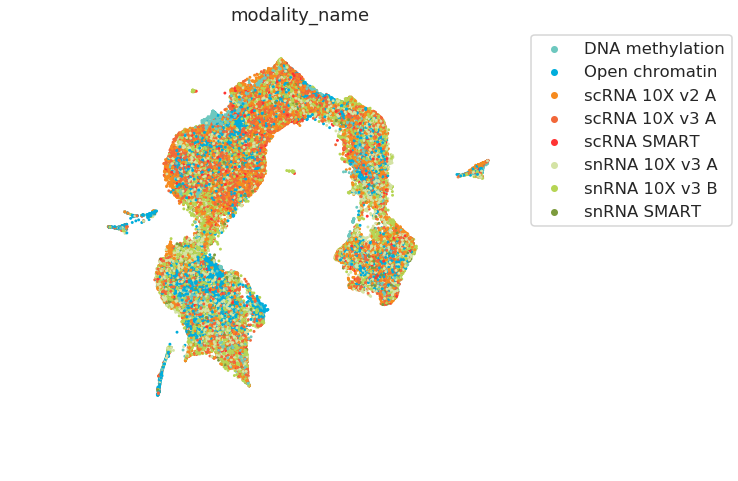

In [24]:
sample_n = 20000

# get cluster centroids
centroids_it = {}
_x = (df_info_it[['tsne_x_joint', 'tsne_y_joint', 'annot', 'modality']]
             .groupby(['modality', 'annot']).median())
for mod in mods_selected:
    centroids_it[mod] = _x.loc[mod, :]
centroids_it['joint'] = (df_info_it[['tsne_x_joint', 'tsne_y_joint', joint_cluster]]
             .groupby([joint_cluster]).median())

# umap cluster
plot_1_single(df_info_it, joint_clst_colors, show_labels=True, centroids=centroids_it, output=output_figures.format('it_1-label', 'pdf'))
plot_1_single(df_info_it, joint_clst_colors, show_labels=False, output=output_figures.format('it_1-nolabel', 'pdf'))
plot_2_single(df_info_it, output=output_figures.format('it_2-nolabel', 'pdf'))

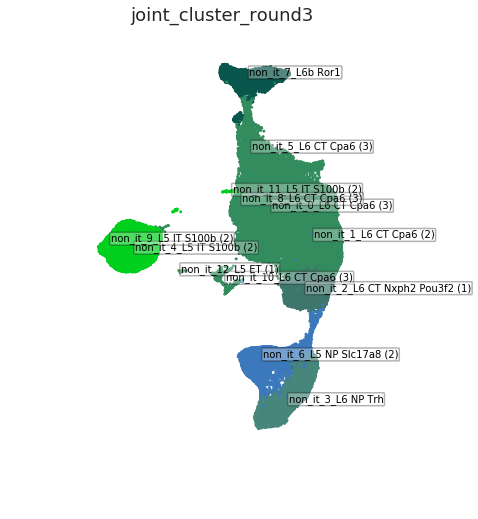

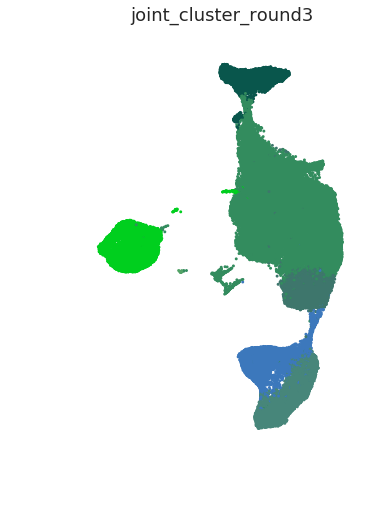

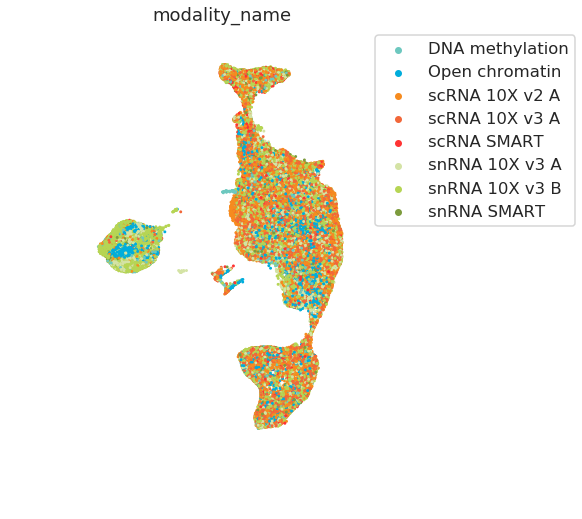

In [23]:
sample_n = 20000

# get cluster centroids
centroids_nonit = {}
_x = (df_info_nonit[['tsne_x_joint', 'tsne_y_joint', 'annot', 'modality']]
             .groupby(['modality', 'annot']).median())
for mod in mods_selected:
    centroids_nonit[mod] = _x.loc[mod, :]
centroids_nonit['joint'] = (df_info_nonit[['tsne_x_joint', 'tsne_y_joint', joint_cluster]]
             .groupby([joint_cluster]).median())

# umap cluster
plot_1_single(df_info_nonit, joint_clst_colors, show_labels=True, centroids=centroids_nonit, output=output_figures.format('nonit_1-label', 'pdf'))
plot_1_single(df_info_nonit, joint_clst_colors, show_labels=False, output=output_figures.format('nonit_1-nolabel', 'pdf'))
plot_2_single(df_info_nonit, output=output_figures.format('nonit_2-nolabel', 'pdf'))

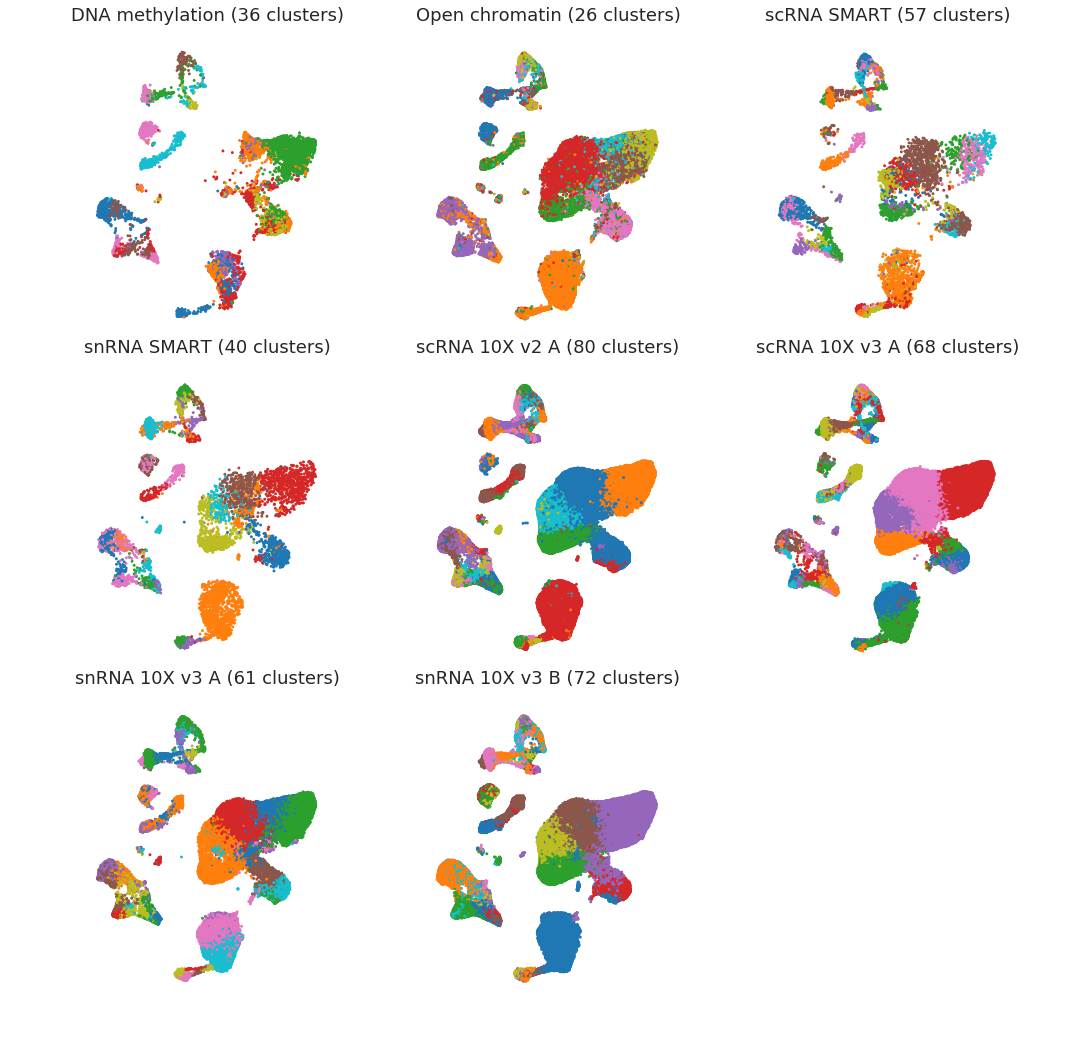

In [42]:
# umap modality
# plot_3(show_labels=True, output=output_figures.format('3-label', 'pdf'))
plot_3(show_labels=False, output=output_figures.format('3-nolabel', 'pdf'))

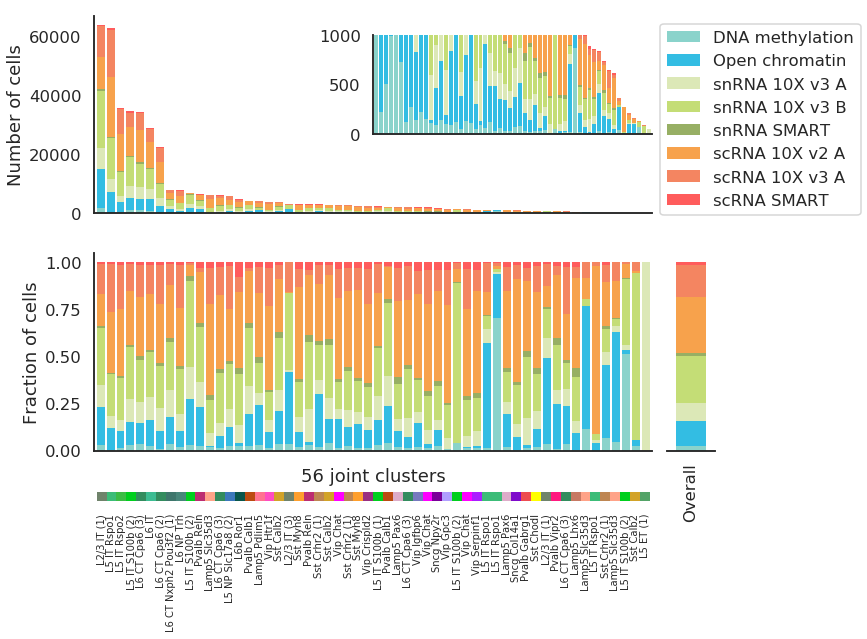

In [43]:
clsts_order = df_info.groupby(joint_cluster).size().sort_values(ascending=False).index.values
mods_ordered_new = [
    'smarter_cells',
    '10x_cells_v3',
    '10x_cells_v2',
    'smarter_nuclei',
    '10x_nuclei_v3_macosko',
    '10x_nuclei_v3',
    'snatac_gene',
    'snmcseq_gene',
][::-1]

# histograms
with sns.axes_style('white', {"patch.edgecolor": "black", 'patch.force_edgecolor': False,}):
    fig, axs = plt.subplots(2, 1, figsize=(10*1,4*2))
    axs = axs.flatten()
    ax = axs[0]
    legend = True
    colors = [mod_colors[key] for key in mods_ordered_new] # this controls mod_colors
    (hist[mods_ordered_new].rename(index=mod_names, columns=mod_names)
                             .reindex(clsts_order)
                             .plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax,
                                       legend=legend,
                                       color=colors, # this controls color order
                                     )
    )
    sns.despine(ax=ax)
    ax.set_ylabel('Number of cells')
    ax.set_xlabel('')
    ax.set_xticklabels([])
    axs[0].legend(bbox_to_anchor=(1, 1))
    
    num_th = 1000
    legend = False
    left_x, left_y, width, height = ax.get_position().bounds
    ax = fig.add_axes((left_x+0.5*width, left_y+0.4*height, 0.5*(width), 0.5*height))
    (hist[mods_ordered_new].rename(index=mod_names, columns=mod_names)
#                              [hist.sum(axis=1)<num_th]
                             .reindex(clsts_order)
                             .plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax,
                                       legend=legend,
                                       color=colors, # this controls color order
                                     )
    )
    sns.despine(ax=ax)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticklabels([])
    ax.set_ylim([0, num_th])
    
    ax = axs[1]
    (hist_frac[mods_ordered_new].rename(index=mod_names, columns=mod_names)
                             .reindex(clsts_order)
                             .plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False, 
                                       color=colors, # this controls color order
                                     )
    )
    sns.despine(ax=ax)
    ax.set_ylabel('Fraction of cells')
    ax.set_xlabel('{} joint clusters'.format(len(hist)))
    ax.set_xticklabels([])
    
#     ax = fig.add_axes([.95, .5, .05, .4])
    left_x, left_y, width, height = ax.get_position().bounds
    ax = fig.add_axes((left_x+width+0.2*(1-(left_x+width)), left_y, 0.3*(1-width), height))
    ((hist_mod/hist_mod.sum()).loc[mods_ordered_new].to_frame().T.rename({0: 'Overall'}, axis=0)
                              .plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False, 
                                       color=colors, # this controls color order
                                       )
    )
    sns.despine(left=True, ax=ax)
    ax.set_ylabel('')
    ax.set_yticklabels([])
    
    ax = fig.add_axes((left_x, left_y-0.7*left_y, width, 0.05*height))
    to_plot = pd.DataFrame()
    to_plot['color'] = joint_annot.loc[hist.reindex(clsts_order).index, 'cluster_color']
    to_plot['annot'] = joint_annot.loc[hist.reindex(clsts_order).index, 'annot']
    to_plot['bar'] = 1
    (to_plot['bar'].plot.bar(stacked=True, width=1, 
                     alpha=1, 
                      ax=ax, 
                      legend=False, 
                     color=to_plot['color'].values, 
                     )
    )
    sns.despine(left=True, bottom=True, ax=ax)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticklabels(to_plot['annot'].values, fontsize=10)
    ax.set_yticks([])
    
    
#     fig.tight_layout()
    fig.savefig(output_figures.format('round3_4', 'pdf'), bbox_inches='tight')
    plt.show()

In [44]:
def plot_5(base_cluster, joint_cluster, 
           output='',
          ):
#     mods_ordered = mods_ordered_new
    nx = len(mods_ordered)
    ny = 2
    heatmap_kws = {
        'xticklabels': False, 
        'yticklabels': False,
        'vmin': 0, 
        'vmax': 1,
        'cmap': 'Reds',
    }

    cbar_kws = {
        'orientation': 'vertical', 
        'label': 'Fraction of cells',
    }

    with sns.plotting_context('talk'):
        fig, axs = plt.subplots(ny, nx, figsize=(3*nx, 3*ny))
        axs = axs.T
        cbar_ax = fig.add_axes([0.95, 0.4, 0.03, 0.3])
        njoint_clusters = len(df_info[joint_cluster].unique())
        for i, (mod, ax) in enumerate(zip(mods_ordered[::-1], axs)):
            if mod == 'snmcseq_gene':
                conf_mat = pd.crosstab(df_info.loc[((df_info['modality']==mod) & (df_info[base_cluster]!='Outlier')), base_cluster], 
                                       df_info.loc[((df_info['modality']==mod) & (df_info[base_cluster]!='Outlier')), joint_cluster],
                                      )
            else:
                conf_mat = pd.crosstab(df_info.loc[df_info['modality']==mod, base_cluster], 
                                       df_info.loc[df_info['modality']==mod, joint_cluster],
                                      )
            # normalize each joint cluster
            conf_mat_njoint = conf_mat.divide(conf_mat.sum(axis=0), axis=1)
            # normalize each orig cluster
            conf_mat_norig = conf_mat.divide(conf_mat.sum(axis=1), axis=0)

            # plot normalized by joint 
            if i == 0:
                # order both row and col
                _X = conf_mat_njoint
                _rX, ri, rc = snmcseq_utils.diag_matrix(_X.values, _X.index.values, _X.columns.values, threshold=0.3)
                _rX = pd.DataFrame(_rX, index=ri, columns=rc)
                g = sns.heatmap(_rX.T, 
                            cbar=True,
                            cbar_kws=cbar_kws,
                            cbar_ax=cbar_ax,
                            ax=ax[0],
                            **heatmap_kws,
                           )
                g.axes.set_title('{}\n{} clusters'.format(mod, _rX.shape[0]))
                g.axes.set_ylabel('Row normalized\n{} joint clusters'.format(njoint_clusters))

                order_joint = _rX.columns.values # Will be fixed for all integrated clusters 
                order_orig = _rX.index.values # Will be fixed for the mod clusters  
            else:
                # order just row (orig)
                _X = conf_mat_njoint.loc[:, order_joint].fillna(0)
                _rX, ri, rc = snmcseq_utils.diag_matrix_rows(_X.values, _X.index.values, _X.columns.values)
                _rX = pd.DataFrame(_rX, index=ri, columns=rc)
                g = sns.heatmap(_rX.T, 
                            cbar=False,
                            ax=ax[0],
                            **heatmap_kws,
                           )
                g.axes.set_title('{}\n{} clusters'.format(settings[mod].name, _rX.shape[0]))
                g.axes.set_ylabel('')

                order_orig = _rX.index.values # Will be fixed for the mod clusters  
            # bounding box
            for _, spine in g.axes.spines.items():
                spine.set_visible(True)
                spine.set_color(settings[mod].color)
    #             spine.set_linewidth(3)

            # plot normalized by orig (according to the axis of normalized by joint) 
            _X = conf_mat_norig.loc[order_orig, order_joint].fillna(0)
            g = sns.heatmap(_X.T, 
                        cbar=False,
                        ax=ax[1],
                        **heatmap_kws,
                       )
            if i == 0:
                g.axes.set_xlabel('')
                g.axes.set_ylabel('Col normalized\n{} joint clusters'.format(njoint_clusters))
            else:
                g.axes.set_xlabel('')
                g.axes.set_ylabel('')
            # bounding box
            for _, spine in g.axes.spines.items():
                spine.set_visible(True)
                spine.set_color(settings[mod].color)
    #             spine.set_linewidth(3)

        plt.subplots_adjust(hspace=0.05, wspace=0.05)
        fig.savefig(output, bbox_inches='tight')
        plt.show()

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


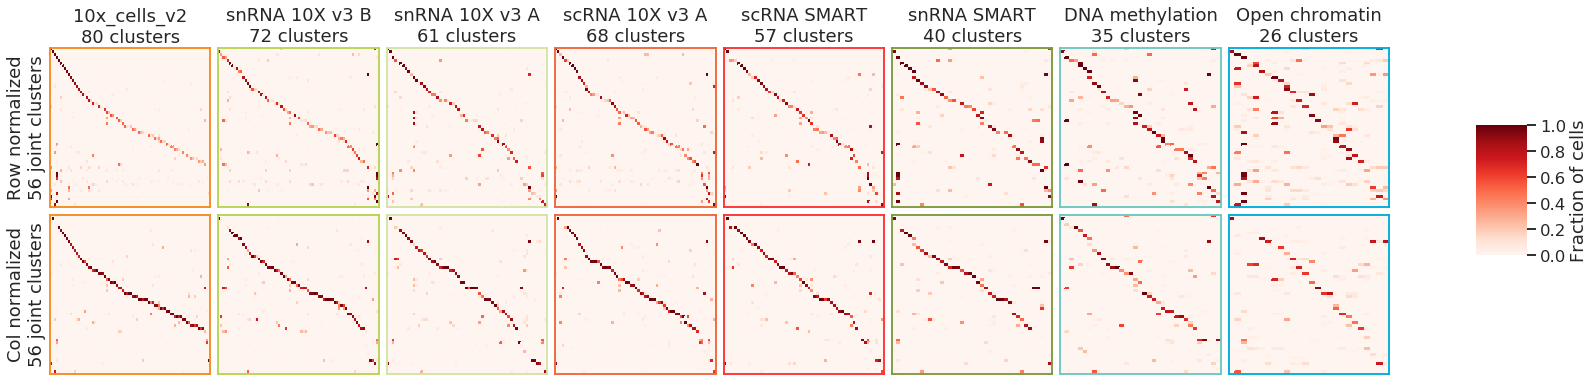

In [45]:
# confusion matrix
base_cluster = 'cluster'
plot_5(base_cluster, joint_cluster, 
       output=output_figures.format(5, 'pdf'),
       )

#### Heatmap of correlation of cluster centroids 
- imputed data

In [19]:
mods_included = mods_selected
mod_reference = features_selected[0]
cells_all = np.load(output_cells_all, allow_pickle=True)
imputed_data = np.load(output_imputed_data_format.format(mod_reference), allow_pickle=True)

# cluster centroids of imputed data
cluster_centroids = collections.OrderedDict()
for (clst, mod), df_sub in df_info.groupby([joint_cluster, 'modality']):
    if mod in mods_included:
        cells_sub = df_sub.index.values
        cells_sub_idx = snmcseq_utils.get_index_from_array(cells_all, cells_sub)
        if mod not in cluster_centroids.keys():
            cluster_centroids[mod] = {}
        cluster_centroids[mod][clst] = np.ravel(imputed_data[cells_sub_idx,:].mean(axis=0))
# print(cluster_centroids)

# Saving the objects:
with open(output_cluster_centroids, 'wb') as f: 
    pickle.dump((
                cluster_centroids
                ), f)

In [20]:
cluster_centroids_df = collections.OrderedDict()
for mod in mods_selected:
    if mod in mods_included:
        cluster_centroids_df[mod] = pd.DataFrame(cluster_centroids[mod])

# each modality and cluster
uniq_clusters = df_info[joint_cluster].unique()
corr_grand_clusters = np.hstack([[mod+'_'+str(clst)
                                for clst in cluster_centroids_df[mod].columns.values]
                                for mod in mods_included])

# grand correlation matrix
corr_grand = {}
for i, mod_x in enumerate(mods_included):
    for j, mod_y in enumerate(mods_included):
        if j >= i:
            gene_x = cluster_centroids_df[mod_x].index.values
            gene_y = cluster_centroids_df[mod_y].index.values
            gene_common = np.intersect1d(gene_x, gene_y)
            _x = (cluster_centroids_df[mod_x].loc[gene_common]).rank(axis=0).T.values
            _y = (cluster_centroids_df[mod_y].loc[gene_common]).rank(axis=0).T.values
            corr = np.corrcoef(_x, _y)[:len(_x), len(_x):]
            corr_grand[(i, j)] = corr
            if j != i:
                corr_grand[(j, i)] = corr.T
                
corr_grand = np.hstack([np.vstack([
                    corr_grand[(i, j)] for i in range(len(mods_included))
                    ])
                for j in range(len(mods_included))
                ])

# labels
# corr_grand_label = np.hstack([[str(clst) + "_" + str(joint_annot.loc[clst, 'annot'])
#                                for clst in cluster_centroids_df[mod].columns.values] 
#                             for mod in mods_included
#                             ])
corr_grand_label = np.hstack([[str(joint_annot.loc[clst, 'annot'])
                               for clst in cluster_centroids_df[mod].columns.values] 
                            for mod in mods_included
                            ])
corr_grand_clsts = np.hstack([cluster_centroids_df[mod].columns.values
                            for mod in mods_included
                            ])
corr_grand_mods = np.hstack([
                            [mod]*len(cluster_centroids_df[mod].columns.values) for mod in mods_included
                            ])

# colors
corr_grand_mod_colors = np.array([settings[mod].color for mod in corr_grand_mods])
corr_grand_clst_colors = np.array([joint_clst_colors[clst] for clst in corr_grand_clsts])

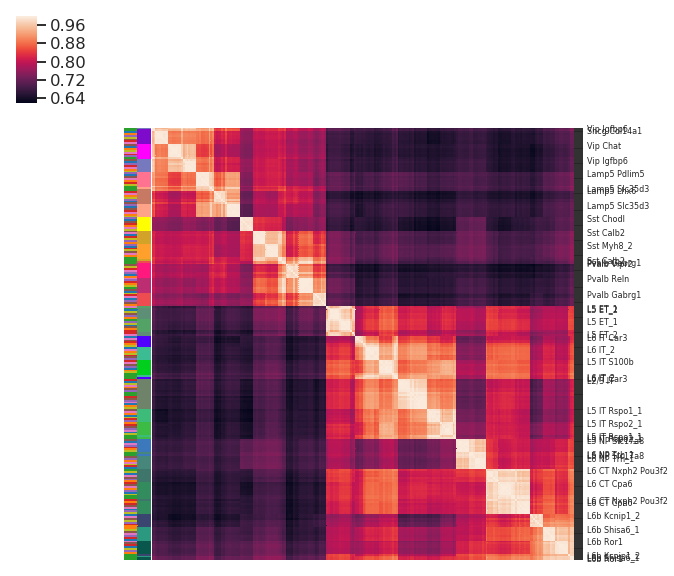

In [21]:
mat = corr_grand
Z = sch.linkage(mat, method='average')
dn = sch.dendrogram(Z, no_plot=True)

g = sns.clustermap(mat[dn['leaves'],:][:,dn['leaves']], 
                   row_cluster=False, col_cluster=False,
                   row_colors=[corr_grand_mod_colors[dn['leaves']], 
                               corr_grand_clst_colors[dn['leaves']], 
                              ], 
                   yticklabels=snmcseq_utils.dedup_array_elements(corr_grand_label[dn['leaves']]),
                   xticklabels=[],
#                    figsize=(8, 12),
                  )
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=8)
g.savefig(output_figures.format('round2_8_cluster_heatmap', 'pdf'), bbox_inches='tight')
plt.show()

In [22]:
def plot_5_version2(base_cluster, joint_cluster, 
                    order_joint,
           output='',
          ):
    nx = len(mods_ordered)
    ny = 2
    heatmap_kws = {
        'xticklabels': False, 
        'yticklabels': False,
        'vmin': 0, 
        'vmax': 1,
        'cmap': 'Reds',
    }

    cbar_kws = {
        'orientation': 'vertical', 
        'label': 'Fraction of cells',
    }

    with sns.plotting_context('talk'):
        fig, axs = plt.subplots(ny, nx, figsize=(3*nx, 3*ny))
        axs = axs.T
        cbar_ax = fig.add_axes([0.95, 0.4, 0.03, 0.3])
        njoint_clusters = len(df_info[joint_cluster].unique())
        for i, (mod, ax) in enumerate(zip(mods_ordered[::-1], axs)):
            conf_mat = pd.crosstab(df_info.loc[df_info['modality']==mod, base_cluster], 
                                   df_info.loc[df_info['modality']==mod, joint_cluster],
                                  ) #.fillna(0)
            # normalize each joint cluster
            conf_mat_njoint = conf_mat.divide(conf_mat.sum(axis=0), axis=1)
            # normalize each orig cluster
            conf_mat_norig = conf_mat.divide(conf_mat.sum(axis=1), axis=0)

            # plot normalized by joint 
            if i == 0:
                ylabel = 'Row normalized\n{} joint clusters'.format(njoint_clusters)
                cbar = True
            else:
                ylabel = ''
                cbar = False
                
            order_joint = order_joint_sch
            _X = conf_mat_njoint.reindex(order_joint, axis=1, fill_value=0) 
            _rX, ri, rc = snmcseq_utils.diag_matrix_rows(_X.values, _X.index.values, _X.columns.values)
            _rX = pd.DataFrame(_rX, index=ri, columns=rc)
            g = sns.heatmap(_rX.T, 
                        cbar=cbar,
                        cbar_kws=cbar_kws,
                        cbar_ax=cbar_ax,
                        ax=ax[0],
                        **heatmap_kws,
                       )
            g.axes.set_title('{}\n{} clusters'.format(settings[mod].name, _rX.shape[0]))
            g.axes.set_ylabel(ylabel)
            order_orig = _rX.index.values # Will be fixed for the mod clusters  
            # bounding box
            for _, spine in g.axes.spines.items():
                spine.set_visible(True)
                spine.set_color(settings[mod].color)

            # plot normalized by orig (according to the axis of normalized by joint) 
            _X = conf_mat_norig.reindex(order_orig, axis=0).reindex(order_joint, axis=1).fillna(0)
            g = sns.heatmap(_X.T, 
                        cbar=False,
                        ax=ax[1],
                        **heatmap_kws,
                       )
            if i == 0:
                g.axes.set_xlabel('')
                g.axes.set_ylabel('Col normalized\n{} joint clusters'.format(njoint_clusters))
            else:
                g.axes.set_xlabel('')
                g.axes.set_ylabel('')
            # bounding box
            for _, spine in g.axes.spines.items():
                spine.set_visible(True)
                spine.set_color(settings[mod].color)

        plt.subplots_adjust(hspace=0.05, wspace=0.05)
        fig.savefig(output, bbox_inches='tight')
        plt.show()

In [23]:
# get cluster order
_mat = pd.DataFrame(cluster_centroids['10x_cells_v2']).T
Z = sch.linkage(_mat.values, method='average')
order_joint_sch = _mat.index.values[sch.dendrogram(Z, no_plot=True)['leaves']]

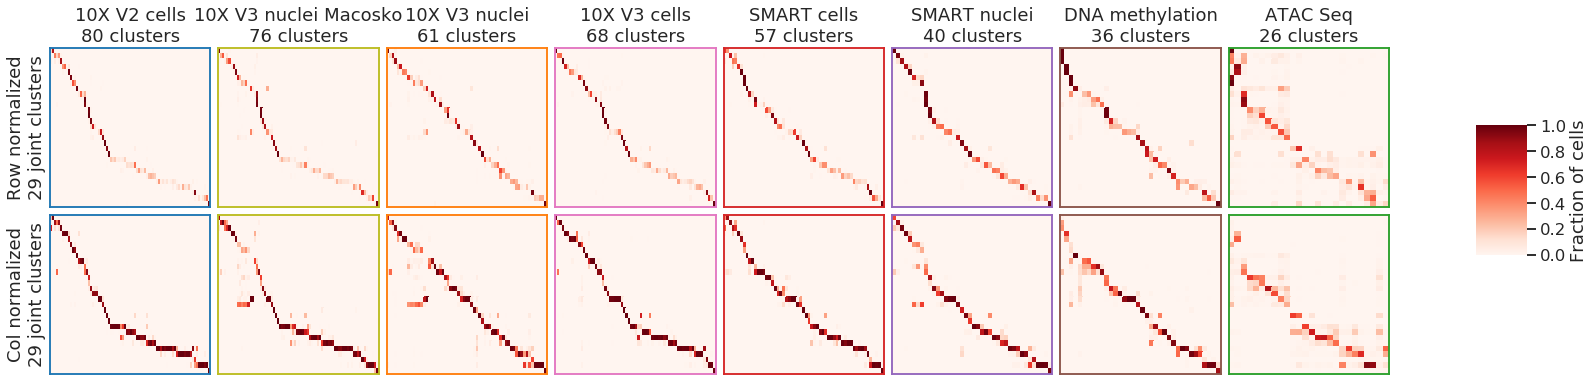

In [24]:
base_cluster = 'cluster'
plot_5_version2(base_cluster, joint_cluster, order_joint_sch, 
       output=output_figures.format('round2_5', 'pdf'),
       )

### tSNE 2 

In [25]:
# cluster centroids of imputed data
base_cluster = 'cluster'
cluster_centroids_single = collections.OrderedDict()
for (clst, mod), df_sub in df_info.groupby([base_cluster, 'modality']):
    if mod in mods_included:
        cells_sub = df_sub.index.values
        cells_sub_idx = snmcseq_utils.get_index_from_array(cells_all, cells_sub)
        if mod not in cluster_centroids_single.keys():
            cluster_centroids_single[mod] = {}
        cluster_centroids_single[mod][clst] = np.ravel(imputed_data[cells_sub_idx,:].mean(axis=0))
        
cluster_centroids_single['intg'] = {}
for clst, df_sub in df_info.groupby([joint_cluster]):
    cells_sub = df_sub.index.values
    cells_sub_idx = snmcseq_utils.get_index_from_array(cells_all, cells_sub)
    cluster_centroids_single['intg'][clst] = np.ravel(imputed_data[cells_sub_idx,:].mean(axis=0))

In [26]:
base_annot = df_info.groupby(['modality', 'cluster']).first()[['annot']].reset_index()
intg_annot = joint_annot.reset_index().rename(columns={joint_cluster: 'cluster'})
intg_annot['modality'] = 'intg'
annots = pd.concat([base_annot, intg_annot], sort=False)

In [27]:
# cluster_centroids
# cluster_meta
dfs = []
centroids_meta = []
        
for mod, mod_centroids in cluster_centroids_single.items():
    df = pd.DataFrame(mod_centroids)
    for col in df.columns.values:
        centroids_meta.append({
            'modality': mod,
            'cluster': col,
            })
    df.columns = [mod + '_' + str(col) for col in df.columns.values]
    dfs.append(df)
dfs = pd.concat(dfs, axis=1)

centroids_meta = pd.DataFrame(centroids_meta)
centroids_meta['sample'] = (centroids_meta['modality'] + '_' + centroids_meta['cluster'].astype(str)).values

print(centroids_meta.shape)
centroids_meta.head()

df_umap = CEMBA_run_tsne.run_umap(dfs, n_neighbors=10, n_pc=50, min_dist=0.7)
df_umap = df_umap.join(centroids_meta.set_index('sample'))
df_umap = pd.merge(df_umap.reset_index(), annots, on=['cluster', 'modality']).set_index('sample')

print(df_umap.shape)
df_umap.head()

(473, 3)


09/26/2019 10:12:08 PM Running tsne: 50 PC, 10 n_neighbors, 0.7 min_dist , 2 dim.
Input shape: (4067, 473)
09/26/2019 10:12:13 PM Done with tSNE. running time: 5.3909947872161865 seconds.


(473, 6)


,tsne_x,tsne_y,cluster,modality,annot,cluster_color
sample,,,,,,
10x_cells_v2_1,-2.253045,-13.347346,1,10x_cells_v2,Lamp5 Pax6,NaN
10x_cells_v2_2,-3.565740,-12.746089,2,10x_cells_v2,Lamp5 Egln3_1,NaN
10x_cells_v2_3,-4.163353,-12.369158,3,10x_cells_v2,Lamp5 Egln3_2,NaN
10x_cells_v2_4,-4.837190,-11.909878,4,10x_cells_v2,Lamp5 Egln3_3,NaN
10x_cells_v2_5,-3.297318,-10.295527,5,10x_cells_v2,Lamp5 Pdlim5,NaN


In [37]:
mod_colors

OrderedDict([('snatac_gene', 'C2'),
             ('snmcseq_gene', 'C5'),
             ('smarter_nuclei', 'C4'),
             ('smarter_cells', 'C3'),
             ('10x_cells_v3', 'C6'),
             ('10x_nuclei_v3', 'C1'),
             ('10x_nuclei_v3_macosko', 'C8'),
             ('10x_cells_v2', 'C0')])

09/26/2019 10:12:13 PM No handles with labels found to put in legend.


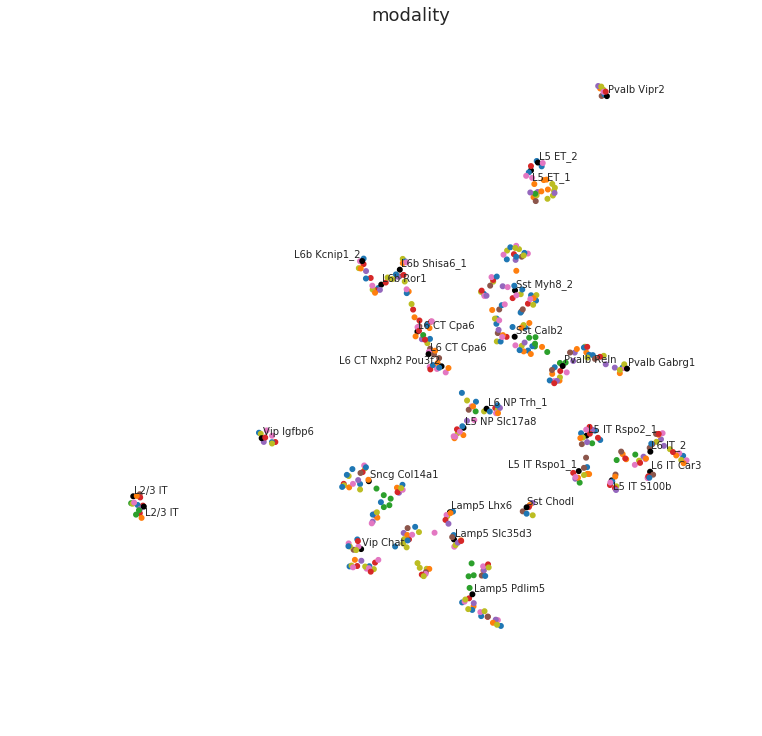

In [28]:
from adjustText import adjust_text
np.random.seed(0)

kw_colors = mod_colors.copy()
kw_colors['intg'] = 'black'

fig, ax = plt.subplots(figsize=(12,12))
tx, ty, tc = 'tsne_x', 'tsne_y', 'modality'
legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
# cond = df_umap['annot'].str.contains(r'^Pv')
cond = ~df_umap['modality'].isnull()
snmcseq_utils.plot_tsne_labels_ax(df_umap[cond], ax, tx, ty, tc, 
                                  legend_kws=legend_kws,
                                  kw_colors=kw_colors,
                                  sample_n=sample_n,
#                                   legend_size=30,
                                  legend_mode=-1,
                                  rasterized=True,
                                  s=20,
                                 )
texts = []
for idx, row in df_umap[df_umap['modality']=='intg'].iterrows():
    _x, _y, _label = row[tx], row[ty], row['annot']
    texts.append(ax.text(_x, _y, _label))
adjust_text(texts)
# ax.set_aspect('equal')
ax.get_legend().remove()
ax.axis('off')
output = output_figures.format('round2_10', 'pdf')
fig.savefig(output, dpi=300, bbox_inches='tight')
plt.show()

# Gene level features:

In [29]:
df_genes = pd.read_csv(PATH_GENEBODY_ANNOTATION, sep='\t')
df_genes['gene_id_abbr'] = df_genes['gene_id'].apply(lambda x: x.split('.')[0])
df_genes = df_genes.set_index('gene_id_abbr')
print(df_genes.shape)
df_genes.head()

(53379, 7)


,gene_id,gene_name,chr,start,end,strand,gene_type
gene_id_abbr,,,,,,,
ENSMUSG00000102693,ENSMUSG00000102693.1,4933401J01Rik,chr1,3073253,3074322,+,TEC
ENSMUSG00000064842,ENSMUSG00000064842.1,Gm26206,chr1,3102016,3102125,+,snRNA
ENSMUSG00000051951,ENSMUSG00000051951.5,Xkr4,chr1,3205901,3671498,-,protein_coding
ENSMUSG00000102851,ENSMUSG00000102851.1,Gm18956,chr1,3252757,3253236,+,processed_pseudogene
ENSMUSG00000103377,ENSMUSG00000103377.1,Gm37180,chr1,3365731,3368549,-,TEC


In [30]:
df_genes_v2 = df_genes.reset_index().groupby('gene_name').first()
df_genes_v2.head()

,gene_id_abbr,gene_id,chr,start,end,strand,gene_type
gene_name,,,,,,,
0610005C13Rik,ENSMUSG00000109644,ENSMUSG00000109644.1,chr7,45567794,45575327,-,antisense_RNA
0610006L08Rik,ENSMUSG00000108652,ENSMUSG00000108652.1,chr7,74818818,74853813,-,lincRNA
0610009B22Rik,ENSMUSG00000007777,ENSMUSG00000007777.9,chr11,51685386,51688874,-,protein_coding
0610009E02Rik,ENSMUSG00000086714,ENSMUSG00000086714.1,chr2,26445696,26459390,+,processed_transcript
0610009L18Rik,ENSMUSG00000043644,ENSMUSG00000043644.4,chr11,120348678,120351190,+,bidirectional_promoter_lncRNA


In [31]:
f_meta_format = '{0}/{1}_metadata.tsv'
f_data_format = '{0}/{1}_{2}raw.{3}'
f_hvftr_format = '{0}/{1}_hvfeatures.{2}'
f_ftr_format = '{0}/{1}_features.{2}'

In [32]:
gxc_ftrs = {}
for mod in mods_selected:
    ti = time.time()
    print(mod)
    
    # read data matrix
    if settings[mod].mod_category == 'mc':
        f_data = f_ftr_format.format(DATA_DIR, mod, 'tsv')
        # read in files
        print(mod, "Reading in files {}".format(time.time()-ti))
        gxc_ftrs[mod] = pd.read_csv(f_data, sep='\t', index_col=0)
        print(time.time()-ti)
        
    else:
        f_data = f_ftr_format.format(DATA_DIR, mod, 'npz') 
        f_data_gene = f_ftr_format.format(DATA_DIR, mod, 'gene') 
        f_data_cell = f_ftr_format.format(DATA_DIR, mod, 'cell') 
        
        # read in files
        print(mod, "Reading in files {}".format(time.time()-ti))
        gxc_ftrs[mod] = snmcseq_utils.load_gc_matrix(f_data_gene, f_data_cell, f_data) # checked dimensions in agreement internally
        print(gxc_ftrs[mod].data.shape)
        print(time.time()-ti)
    
    print(mod, "Total time used: {}".format(time.time()-ti))
    

snmcseq_gene
snmcseq_gene Reading in files 0.00010371208190917969
115.38135600090027
snmcseq_gene Total time used: 115.38155269622803
snatac_gene
snatac_gene Reading in files 3.981590270996094e-05
(53278, 54844)
30.398054599761963
snatac_gene Total time used: 30.39811396598816
smarter_cells
smarter_cells Reading in files 7.748603820800781e-05
(32324, 6244)
10.923522472381592
smarter_cells Total time used: 10.923560619354248
smarter_nuclei
smarter_nuclei Reading in files 4.410743713378906e-05
(32324, 5911)
5.727839708328247
smarter_nuclei Total time used: 5.727876424789429
10x_cells_v2
10x_cells_v2 Reading in files 4.363059997558594e-05
(31053, 121440)
58.38835310935974
10x_cells_v2 Total time used: 58.38838243484497
10x_cells_v3
10x_cells_v3 Reading in files 5.1975250244140625e-05
(31053, 69727)
54.207035779953
10x_cells_v3 Total time used: 54.20708632469177
10x_nuclei_v3
10x_nuclei_v3 Reading in files 6.508827209472656e-05
(31053, 39706)
14.521170139312744
10x_nuclei_v3 Total time use

### gene heatmap new

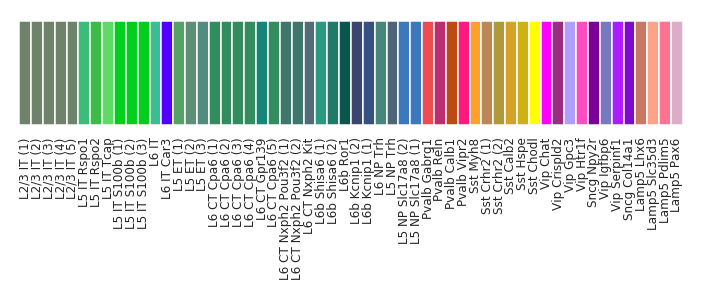

In [119]:
clsts_manual_order = collections.OrderedDict({
      '4-1-1': 'L2/3 IT ',
      '4-1-2': 'L2/3 IT ',
      '4-2-1': 'L2/3 IT ',
      '4-2-2': 'L2/3 IT ',
      '4-2-3': 'L2/3 IT ',
      '1-1-1': 'L5 IT Rspo1_1',
      '1-2-1': 'L5 IT Rspo2_1',
      '1-2-2': 'L5 IT Tcap_1',
      '3-1-2': 'L5 IT S100b',
      '3-2-1': 'L5 IT S100b',
      '3-2-2': 'L5 IT S100b',
      '3-1-1': 'L6 IT_2',
      '3-3-1': 'L6 IT Car3',
    
      '9-1-1': 'L5 ET_1',
      '9-2-1': 'L5 ET_2',
      '9-2-2': 'L5 ET_3',
    
      '2-1-1': 'L6 CT Cpa6',
      '2-1-2': 'L6 CT Cpa6',
      '2-2-1': 'L6 CT Cpa6',
      '2-2-2': 'L6 CT Cpa6',
      '2-2-3': 'L6 CT Gpr139',
      '2-2-4': 'L6 CT Cpa6',
      '2-3-1': 'L6 CT Nxph2 Pou3f2',
      '2-3-2': 'L6 CT Nxph2 Pou3f2',
      '2-3-3': 'L6 CT Nxph2 Kit',
    
      '8-1-1': 'L6b Shisa6_1',
      '8-1-2': 'L6b Shisa6_2_2',
      '8-2-1': 'L6b Ror1',
      '8-3-1': 'L6b Kcnip1_2',
      '8-3-2': 'L6b Kcnip1_2',
    
      '7-1-1': 'L6 NP Trh_1',
      '7-1-2': 'L5 NP Trh',
      '7-2-1': 'L5 NP Slc17a8',
      '7-2-2': 'L5 NP Slc17a8',
    
      '5-4-1': 'Pvalb Gabrg1',
      '5-1-1': 'Pvalb Reln',
      '5-1-2': 'Pvalb Calb1_1',
      '5-5-1': 'Pvalb Vipr2',
    
      '5-2-1': 'Sst Myh8_2',
      '5-2-2': 'Sst Crhr2_1',
      '5-2-3': 'Sst Crhr2_2',
      '5-3-1': 'Sst Calb2',
      '5-3-2': 'Sst Hspe_3',
      '10-1-1': 'Sst Chodl',
    
      '6-1-1': 'Vip Chat',
      '6-1-2': 'Vip Crispld2',
      '6-3-1': 'Vip Gpc3',
      '6-3-2': 'Vip Htr1f_1',
      '6-5-3': 'Sncg Npy2r',
      '6-3-3': 'Vip Igfbp6',
      '6-5-2': 'Vip Serpinf1_2',
      '6-5-1': 'Sncg Col14a1',
    
      '6-6-1': 'Lamp5 Lhx6',
      '6-2-1': 'Lamp5 Slc35d3',
      '6-4-1': 'Lamp5 Pdlim5',
      '6-4-2': 'Lamp5 Pax6',
    
})

with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(12, 2))
    clsts_uniq = np.array(list(clsts_manual_order.keys()))
    to_plot = pd.DataFrame()
    to_plot['color'] = joint_annot.loc[clsts_uniq, 'cluster_color']
    to_plot['bar'] = 1
    to_plot['text'] = joint_annot.loc[clsts_uniq, 'annot']
    (to_plot['bar'].plot.bar(stacked=True, width=1, 
                             alpha=1, 
                             ax=ax,
    #                          legend=False, 
                             color=to_plot['color'].values, 
                             )
    )
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_xticklabels(to_plot['text'].values, fontsize=12)
    ax.set_yticks([])
    ax.set_xlabel('')
    
    output = output_figures.format('round3_sidebar', 'pdf')
    fig.savefig(output, dpi=300, bbox_inches='tight')
    plt.show()